In [1]:
from matplotlib import pyplot as plt
from matplotlib.path import Path
from numpy import ones
from datetime import datetime

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.observations.observation import EddiesObservations
from py_eddy_tracker.poly import create_vertice


date = datetime(2020, 2, 1)

outtestdir='/work/bm1344/m300466/ngc3/'
a = EddiesObservations.load_file(outtestdir+"ngc3028_anticyclonic_"+date.strftime('%Y%m%d')+".nc")
c = EddiesObservations.load_file(outtestdir+"ngc3028_cyclonic_"+date.strftime('%Y%m%d')+".nc")



In [4]:
#Load Input grid, SSH is used to detect eddies. Add a new filed to store the high-pass filtered SSHA
#Read in example SSH data that has been mapped onto a 0.25deg regular grid.
outdir='/work/mh0256/m301014/eddy-track/data/interim/'
grid_name, lon_name, lat_name = (
    outdir+'icon_ngc3028_0.25DEG_interp_zos.nc',
    "lon",
    "lat",
)

g = RegularGridDataset(grid_name, lon_name, lat_name)
g.add_uv("zos")
g.copy("zos", "zos_high")
wavelength = 700  #choice of spatial cutoff for high pass filter in km
g.bessel_high_filter("zos", wavelength, order=1)
date = datetime(2020, 2, 1)


We assume pixel position of grid is centered for /work/mh0256/m301014/eddy-track/data/interim/icon_ngc3028_0.25DEG_interp_zos.nc
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
No filtering above 85.000000 degrees of latitude


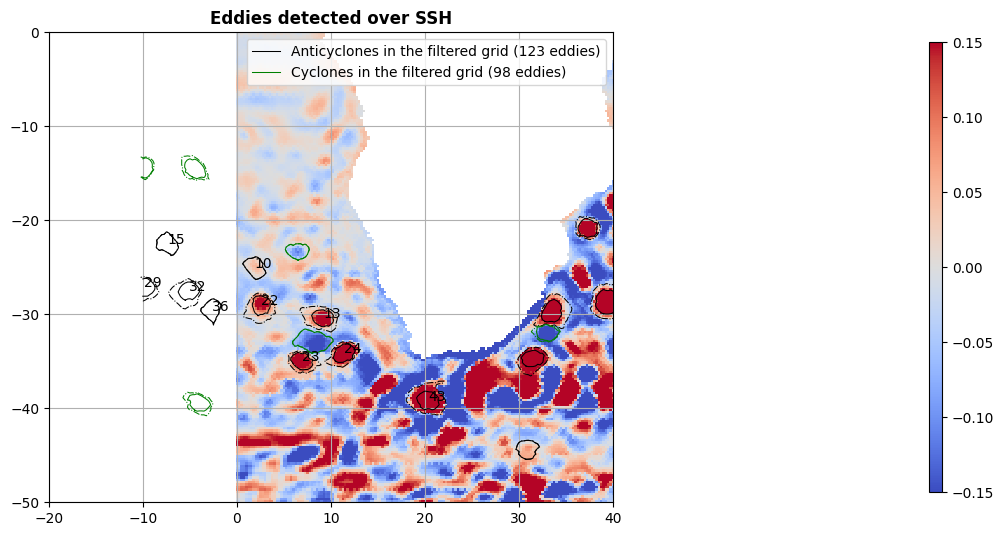

In [3]:
#Identify anticyclones in Agulhas leakage region and their respective IDs. 
def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    ax.set_xlim(-20,40), ax.set_ylim(-50,0)
    ax.set_aspect("equal")
    ax.set_title(title, weight="bold")
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

ax = start_axes("Eddies detected over SSH")
m = g.display(ax, "zos", vmin=-0.15, vmax=0.15)
a.display(
    ax,
    lw=0.75,
    label="Anticyclones in the filtered grid ({nb_obs} eddies)",
    ref=-10,
    color="k",
)
c.display(
    ax, lw=0.75, label="Cyclones in the filtered grid ({nb_obs} eddies)", 
    ref=-10, 
    color="green"
)
ax.legend()
update_axes(ax, m)

#Get eddy ID# for region around Agulhas leakage
import numpy as np
ARidx = np.argwhere(((a.lat<=-20) & (a.lat>=-45) & (a.lon>350)) | ((a.lat<=-20) & (a.lat>=-45) & (a.lon<30)) ) 

for ii in range(len(ARidx)):
    if a.longitude[ARidx][ii]>180:
        # ax.text(a.longitude[ARidx][ii][0]-360,a.latitude[ARidx][ii][0],str(a_filtered.num_point_e[ARidx][ii][0]))
        ax.text(a.longitude[ARidx][ii][0]-360,a.latitude[ARidx][ii][0],str(ARidx[ii][0]))
    else:
        ax.text(a.longitude[ARidx][ii][0],a.latitude[ARidx][ii][0],str(ARidx[ii][0]))

In [6]:
#Now we make composites that are 2deg from eddy centre based on only full fields (no filtering done yet)
dlon=2.
dlat=2.

import xarray as xr

outdir='/work/mh0256/m301014/eddy-track/data/interim/'
dssh=xr.open_dataset(outdir+'icon_ngc3028_0.25DEG_interp_zos.nc')
SSH=dssh.zos.sel(time=date.strftime('%Y-%m-%d'))

SSHcomp=[]

for ii in range(len(ARidx)):
    print('Eddy ID: ',str(ARidx[ii][0]))
    print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
    print('Effective radius = '+str(a.radius_e[ARidx][ii][0])+'m')
    lonmin=a.lon[ARidx][ii][0]-dlon
    lonmax=a.lon[ARidx][ii][0]+dlon
    latmin=a.lat[ARidx][ii][0]-dlat
    latmax=a.lat[ARidx][ii][0]+dlat
    SSHcomp.append(SSH.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))

10
Eddy center: lon=1.8975298404693604, lat=-25.053396224975586
Effective radius = 116800.0
13
Eddy center: lon=9.149621963500977, lat=-30.39912223815918
Effective radius = 167450.0
15
Eddy center: lon=352.6099548339844, lat=-22.524925231933594
Effective radius = 118300.0
22
Eddy center: lon=2.567488670349121, lat=-29.03944206237793
Effective radius = 161650.0
23
Eddy center: lon=6.903814792633057, lat=-35.00080871582031
Effective radius = 135800.0
24
Eddy center: lon=11.386496543884277, lat=-34.15673828125
Effective radius = 145800.0
29
Eddy center: lon=350.13128662109375, lat=-27.142221450805664
Effective radius = 137950.0
32
Eddy center: lon=354.8802185058594, lat=-27.52893829345703
Effective radius = 162250.0
36
Eddy center: lon=357.3558349609375, lat=-29.626474380493164
Effective radius = 112650.0
43
Eddy center: lon=20.335779190063477, lat=-39.18265151977539
Effective radius = 184500.0


Eddy ID:  10
Eddy ID:  13
Eddy ID:  15
Eddy ID:  22
Eddy ID:  23
Eddy ID:  24
Eddy ID:  29
Eddy ID:  32
Eddy ID:  36
Eddy ID:  43


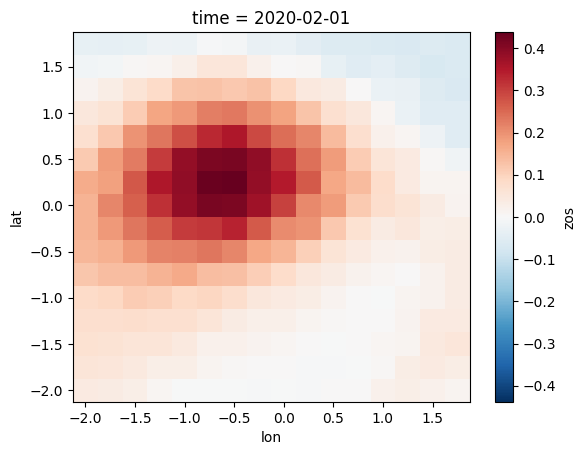

In [13]:
# To merge the data, lon/lat needs recentering. For now, we just use issue with different lon/lat

res=0.25
npts=int(dlon/res) #number of points from centre
for ii in range(len(ARidx)):
    print('Eddy ID: ',str(ARidx[ii][0]))
    SSHcomp[ii]=SSHcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)

    
fig, ax = plt.subplots()
xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)


In [14]:
dswspd=xr.open_dataset(outdir+'icon_ngc3028_0.25DEG_interp_wind_speed_10m.nc')
WSPD=dswspd.wind_speed_10m.sel(time=date.strftime('%Y-%m-%d'))

WSPDcomp=[]
for ii in range(len(ARidx)):
    print(ARidx[ii][0])
    print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
    print('Effective radius = '+str(a.radius_e[ARidx][ii][0]))
    lonmin=a.lon[ARidx][ii][0]-dlon
    lonmax=a.lon[ARidx][ii][0]+dlon
    latmin=a.lat[ARidx][ii][0]-dlat
    latmax=a.lat[ARidx][ii][0]+dlat
    WSPDcomp.append(WSPD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))

10
Eddy center: lon=1.8975298404693604, lat=-25.053396224975586
Effective radius = 116800.0
13
Eddy center: lon=9.149621963500977, lat=-30.39912223815918
Effective radius = 167450.0
15
Eddy center: lon=352.6099548339844, lat=-22.524925231933594
Effective radius = 118300.0
22
Eddy center: lon=2.567488670349121, lat=-29.03944206237793
Effective radius = 161650.0
23
Eddy center: lon=6.903814792633057, lat=-35.00080871582031
Effective radius = 135800.0
24
Eddy center: lon=11.386496543884277, lat=-34.15673828125
Effective radius = 145800.0
29
Eddy center: lon=350.13128662109375, lat=-27.142221450805664
Effective radius = 137950.0
32
Eddy center: lon=354.8802185058594, lat=-27.52893829345703
Effective radius = 162250.0
36
Eddy center: lon=357.3558349609375, lat=-29.626474380493164
Effective radius = 112650.0
43
Eddy center: lon=20.335779190063477, lat=-39.18265151977539
Effective radius = 184500.0


Eddy ID:  10
Eddy ID:  13
Eddy ID:  15
Eddy ID:  22
Eddy ID:  23
Eddy ID:  24
Eddy ID:  29
Eddy ID:  32
Eddy ID:  36
Eddy ID:  43


<a list of 4 text.Text objects>

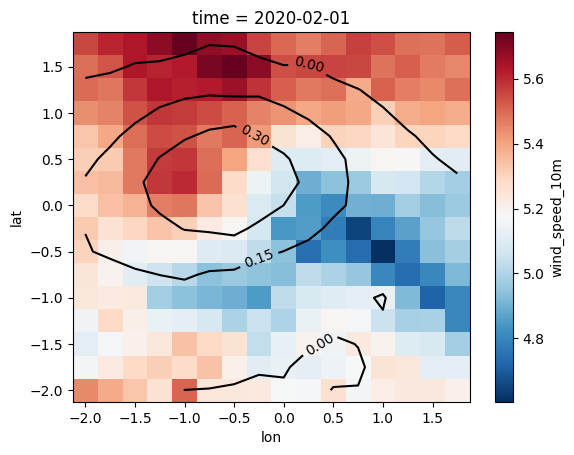

In [15]:
for ii in range(len(ARidx)):
    print('Eddy ID: ',str(ARidx[ii][0]))
    WSPDcomp[ii]=WSPDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)
    
fig, ax = plt.subplots()
xr.concat(WSPDcomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').plot.contour(cmap='k', ax=ax)
ax.clabel(CS)

In [16]:
dshfls=xr.open_dataset(outdir+'icon_ngc3028_0.25DEG_interp_atmos_fluxes_heatflux_latent.nc')
HFLS=dshfls.atmos_fluxes_heatflux_latent.sel(time=date.strftime('%Y-%m-%d'))

HFLScomp=[]
for ii in range(len(ARidx)):
    print(ARidx[ii][0])
    print('Eddy center: lon='+str(a.lon[ARidx][ii][0])+', lat='+str(a.lat[ARidx][ii][0]))
    print('Effective radius = '+str(a.radius_e[ARidx][ii][0]))
    lonmin=a.lon[ARidx][ii][0]-dlon
    lonmax=a.lon[ARidx][ii][0]+dlon
    latmin=a.lat[ARidx][ii][0]-dlat
    latmax=a.lat[ARidx][ii][0]+dlat
    HFLScomp.append(HFLS.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)))

10
Eddy center: lon=1.8975298404693604, lat=-25.053396224975586
Effective radius = 116800.0
13
Eddy center: lon=9.149621963500977, lat=-30.39912223815918
Effective radius = 167450.0
15
Eddy center: lon=352.6099548339844, lat=-22.524925231933594
Effective radius = 118300.0
22
Eddy center: lon=2.567488670349121, lat=-29.03944206237793
Effective radius = 161650.0
23
Eddy center: lon=6.903814792633057, lat=-35.00080871582031
Effective radius = 135800.0
24
Eddy center: lon=11.386496543884277, lat=-34.15673828125
Effective radius = 145800.0
29
Eddy center: lon=350.13128662109375, lat=-27.142221450805664
Effective radius = 137950.0
32
Eddy center: lon=354.8802185058594, lat=-27.52893829345703
Effective radius = 162250.0
36
Eddy center: lon=357.3558349609375, lat=-29.626474380493164
Effective radius = 112650.0
43
Eddy center: lon=20.335779190063477, lat=-39.18265151977539
Effective radius = 184500.0


Eddy ID:  10
Eddy ID:  13
Eddy ID:  15
Eddy ID:  22
Eddy ID:  23
Eddy ID:  24
Eddy ID:  29
Eddy ID:  32
Eddy ID:  36
Eddy ID:  43


<a list of 4 text.Text objects>

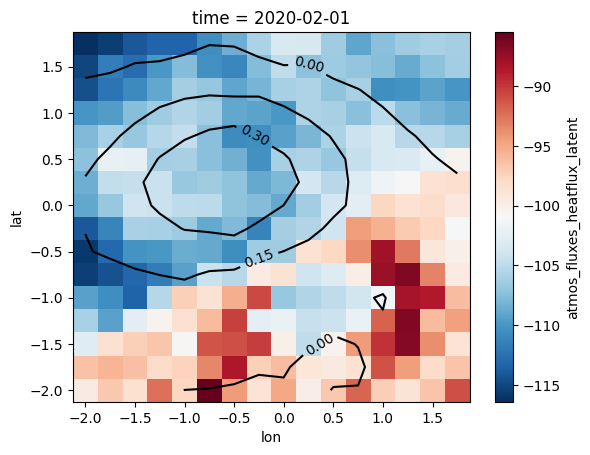

In [17]:
for ii in range(len(ARidx)):
    print('Eddy ID: ',str(ARidx[ii][0]))
    HFLScomp[ii]=HFLScomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)
    
fig, ax = plt.subplots()
xr.concat(HFLScomp,dim='eddy').mean(dim='eddy').plot(cmap='RdBu_r', ax=ax)
CS = xr.concat(SSHcomp,dim='eddy').mean(dim='eddy').plot.contour(cmap='k', ax=ax)
ax.clabel(CS)